1. Таблица рисков

| ID  | Риск | Вероятность | Влияние | Рейтинг | Стратегия реагирования | Превентивные меры |
|-----|------|-------------|---------|---------|------------------------|-------------------|
| R1  | Недостаточная сила ИИ-оппонента (предсказуемость, слабые стратегии) | Средняя | Высокое | Высокий | Снижение | • Добавить несколько стратегий поведения<br>• Регулярные плейтесты<br>• Настройка параметров сложности |
| R2  | Риск «золотого молотка» — чрезмерное усложнение ИИ | Средняя | Среднее | Средний | Снижение | • Начать с простого MVP-ИИ<br>• Ограничить глубину логики<br>• Сравнивать с базовыми эвристиками |
| R3  | Дисбаланс карт | Высокая | Высокое | Высокое | Снижение | • Тестировать колоды <br>• Регулярно корректировать параметры |
| R4  | Сложность UI/UX (неудобный интерфейс для игрока) | Средняя | Среднее | Средний | Снижение | • Делать прототипы интерфейса<br>• Получать обратную связь от игроков<br>• Улучшать по результатам тестов |
| R5  | Сложности работы в команде | Средняя | Высокое | Критический | Снижение | • Использовать систему задач (Trello/Jira/Yougile)<br>• Регулярные встречи<br>• Чёткое распределение ролей |
| R6  | Недостаточное тестирование | Средняя | Высокое | Критический | Снижение | • Планировать время на тестирование<br>• Привлекать внешних тестировщиков (всех друзей и друзей друзей) |
| R7  | Срыв сроков из-за недооценки сложности ИИ или остальной части игры | Высокая | Высокое | Критический | Избежание | • Делить проект на этапы<br>• Определить и делать в первую очередь наиболее необходимые задачи<br>• Закладывать запас времени на все |
| R8  | Проблемы с работой ПО (баги, ошибки в Unity) | Средняя | Низкое | Низкое | Снижение | • Использовать стабильные версии Unity<br>• Регулярные резервные копии |


2. Диаграмма Ганта

In [1]:
def create_gantt_chart(tasks, title="Диаграмма Ганта", save_path="gantt_chart.png", figsize=(16, 8)):
    """
    Создает и сохраняет диаграмму Ганта в виде таблицы на основе предоставленных данных о задачах.

    Параметры:
    ----------
    tasks : list of dict
        Список словарей, каждый из которых содержит информацию о задаче в формате:
        {"Task": "Название задачи", "Start": "YYYY-MM-DD", "End": "YYYY-MM-DD", "Group": "Группа задачи"}
    title : str, optional
        Заголовок диаграммы
    save_path : str, optional
        Путь для сохранения изображения
    figsize : tuple, optional
        Размер изображения (ширина, высота) в дюймах

    Возвращает:
    -----------
    None (сохраняет изображение и отображает его)
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from datetime import datetime, timedelta

    # Создание DataFrame и преобразование дат
    df = pd.DataFrame(tasks)
    df['Start'] = pd.to_datetime(df['Start'])
    df['End'] = pd.to_datetime(df['End'])

    # Определение временного диапазона проекта
    project_start = df['Start'].min().date()
    project_end = df['End'].max().date()
    project_duration = (project_end - project_start).days + 1

    # Создание всех дат проекта
    all_dates = [project_start + timedelta(days=i) for i in range(project_duration)]
    date_labels = [date.strftime('%d-%m') for date in all_dates]

    # Создание длинного формата данных для heatmap
    gantt_data = []
    for i, task in enumerate(df.itertuples()):
        task_start = task.Start.date()
        task_end = task.End.date()
        for date in all_dates:
            is_active = 1 if task_start <= date <= task_end else 0
            gantt_data.append({
                'Task': task.Task,
                'Date': date.strftime('%Y-%m-%d'),
                'Active': is_active,
                'Group': task.Group
            })

    # Преобразование в DataFrame
    gantt_df = pd.DataFrame(gantt_data)

    # Преобразование в матричный формат для heatmap
    gantt_matrix = gantt_df.pivot(index='Task', columns='Date', values='Active')

    # Получение уникальных групп задач
    groups = df['Group'].unique()

    # Создание цветовой схемы для групп
    group_values = {group: i+1 for i, group in enumerate(groups)}

    # Создание матрицы с группами
    group_matrix = np.zeros_like(gantt_matrix.values)
    for i, task in enumerate(gantt_matrix.index):
        group = df[df['Task'] == task]['Group'].values[0]
        group_value = group_values[group]
        active_indices = np.where(gantt_matrix.iloc[i, :] == 1)
        group_matrix[i, active_indices] = group_value

    # Настройка цветовой схемы - исправлено для устранения deprecation warning
    num_colors = len(group_values) + 1
    cmap = plt.colormaps['Paired']  # Используем plt.colormaps вместо plt.cm.get_cmap
    colors = [cmap(i/(num_colors-1)) for i in range(num_colors)]
    custom_cmap = plt.matplotlib.colors.ListedColormap(['white'] + colors[1:])

    # Создание фигуры с дополнительным пространством для легенды
    fig, ax = plt.subplots(figsize=figsize)

    # Создание heatmap с seaborn
    ax = sns.heatmap(group_matrix, cmap=custom_cmap, cbar=False,
                    linewidths=.5, linecolor='gray',
                    xticklabels=date_labels, yticklabels=gantt_matrix.index, ax=ax)

    # Настройка осей
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Дата', fontsize=12)
    ax.set_ylabel('Задача', fontsize=12)

    # Настройка частоты меток по оси X (каждые 7 дней)
    tick_positions = np.arange(0, project_duration, 7)
    ax.set_xticks(tick_positions)
    ax.set_xticklabels([all_dates[pos].strftime('%d-%m-%Y') for pos in tick_positions], rotation=45)

    # Добавление сетки для недель
    for week_pos in tick_positions:
        plt.axvline(x=week_pos, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

    # Добавление легенды вне области графика
    legend_elements = [plt.Rectangle((0, 0), 1, 1, facecolor=colors[group_values[group]],
                                    edgecolor='gray', label=group)
                      for group in group_values.keys()]

    # Размещаем легенду вне области графика (справа от диаграммы)
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.02, 0.5),
             fontsize=10, frameon=True, fancybox=True, shadow=True)

    # Оптимизация размещения
    plt.tight_layout()

    # Сохранение с высоким разрешением
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

Вся диаграмма:

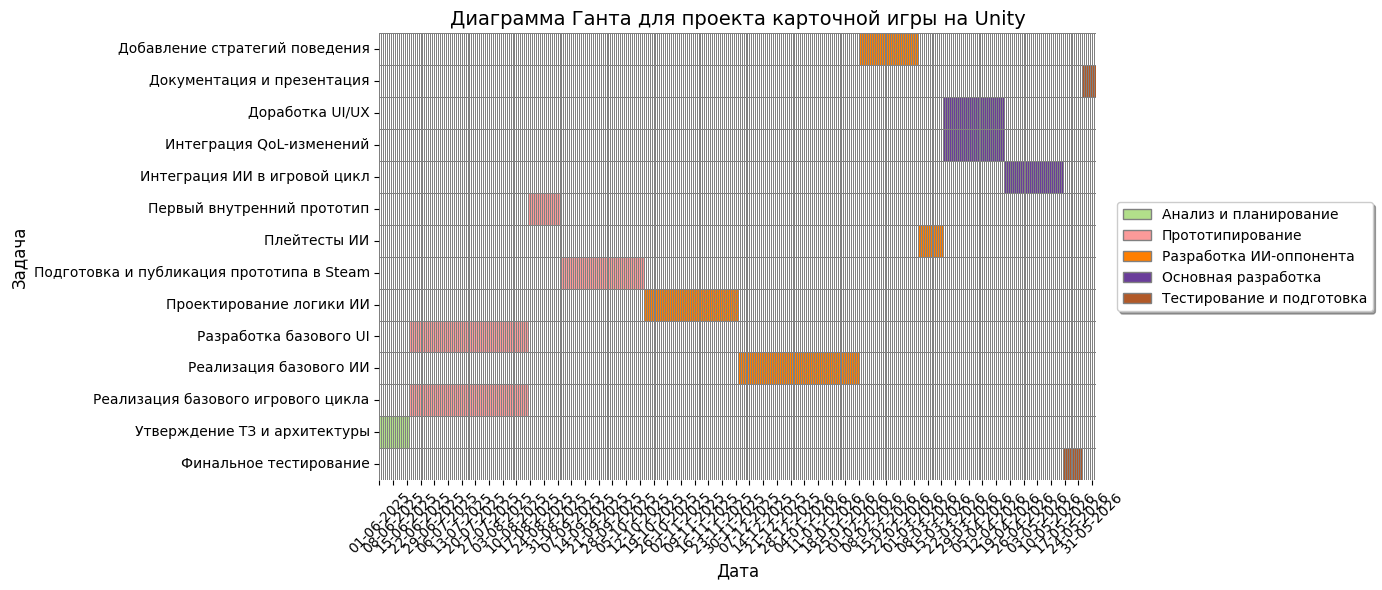

In [6]:
# Список задач по одной-две основные из каждой группы
sample_tasks = [
    {"Task": "Утверждение ТЗ и архитектуры", "Start": "2025-06-01", "End": "2025-06-15", "Group": "Анализ и планирование"},

    {"Task": "Реализация базового игрового цикла", "Start": "2025-06-16", "End": "2025-08-15", "Group": "Прототипирование"},
    {"Task": "Разработка базового UI", "Start": "2025-06-16", "End": "2025-08-15", "Group": "Прототипирование"},
    {"Task": "Первый внутренний прототип", "Start": "2025-08-16", "End": "2025-09-01", "Group": "Прототипирование"},
    {"Task": "Подготовка и публикация прототипа в Steam", "Start": "2025-09-02", "End": "2025-10-13", "Group": "Прототипирование"},

    {"Task": "Проектирование логики ИИ", "Start": "2025-10-14", "End": "2025-11-30", "Group": "Разработка ИИ-оппонента"},
    {"Task": "Реализация базового ИИ", "Start": "2025-12-01", "End": "2026-01-31", "Group": "Разработка ИИ-оппонента"},
    {"Task": "Добавление стратегий поведения", "Start": "2026-02-01", "End": "2026-03-02", "Group": "Разработка ИИ-оппонента"},
    {"Task": "Плейтесты ИИ", "Start": "2026-03-03", "End": "2026-03-15", "Group": "Разработка ИИ-оппонента"},

    {"Task": "Интеграция QoL-изменений", "Start": "2026-03-16", "End": "2026-04-15", "Group": "Основная разработка"},
    {"Task": "Доработка UI/UX", "Start": "2026-03-16", "End": "2026-04-15", "Group": "Основная разработка"},
    {"Task": "Интеграция ИИ в игровой цикл", "Start": "2026-04-16", "End": "2026-05-15", "Group": "Основная разработка"},

    {"Task": "Финальное тестирование", "Start": "2026-05-16", "End": "2026-05-25", "Group": "Тестирование и подготовка"},
    {"Task": "Документация и презентация", "Start": "2026-05-26", "End": "2026-06-01", "Group": "Тестирование и подготовка"}
]

# Вызов функции для создания диаграммы Ганта
create_gantt_chart(
    tasks=sample_tasks,
    title="Диаграмма Ганта для проекта карточной игры на Unity",
    save_path="gantt_chart_unity_card_game.png",
    figsize=(14, 6)
)


Разделенная на части для удобства:

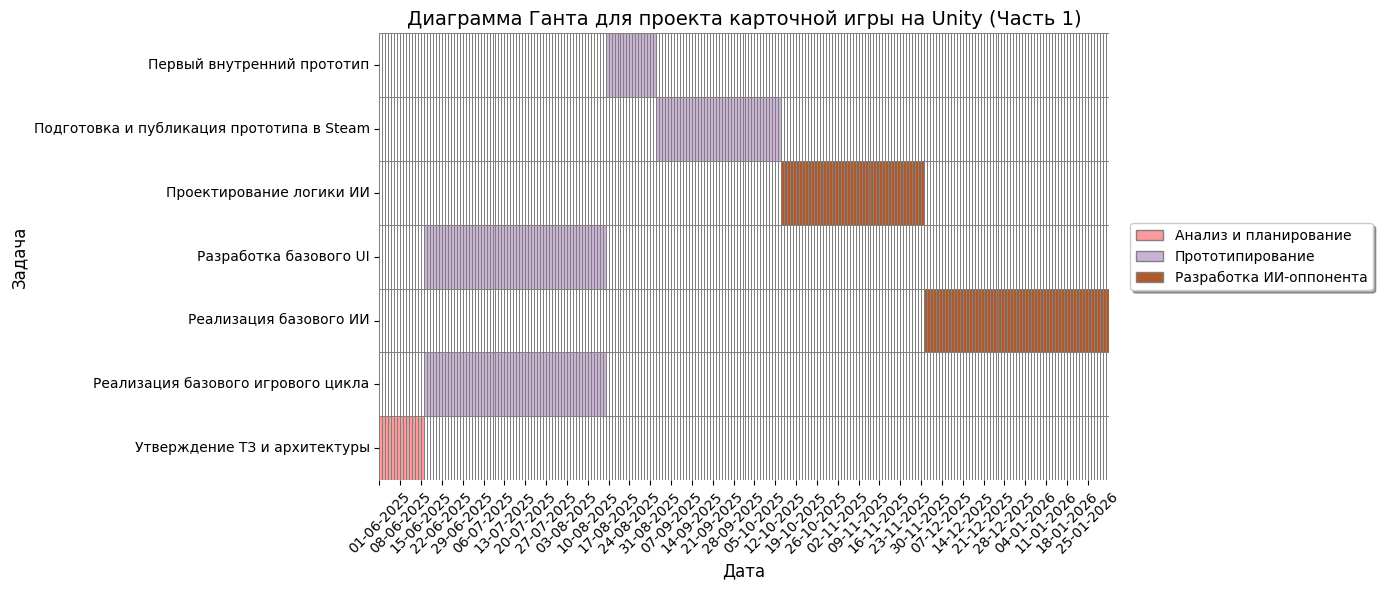

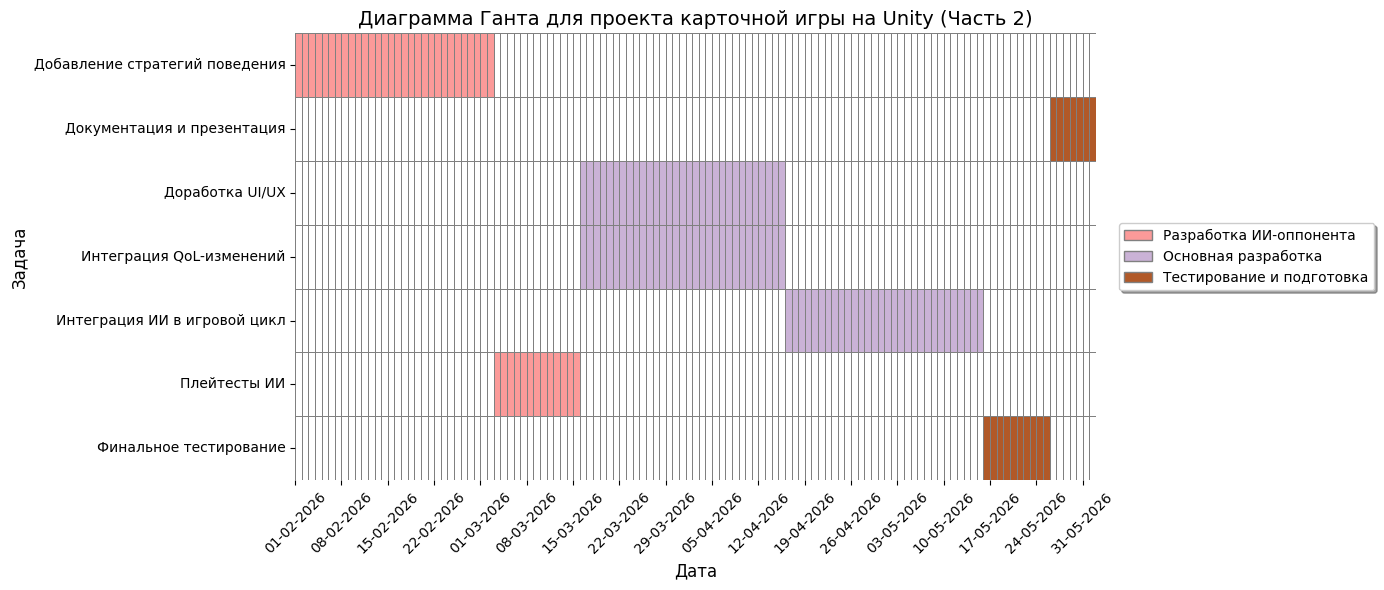

In [8]:
sample_tasks = [
    {"Task": "Утверждение ТЗ и архитектуры", "Start": "2025-06-01", "End": "2025-06-15", "Group": "Анализ и планирование"},

    {"Task": "Реализация базового игрового цикла", "Start": "2025-06-16", "End": "2025-08-15", "Group": "Прототипирование"},
    {"Task": "Разработка базового UI", "Start": "2025-06-16", "End": "2025-08-15", "Group": "Прототипирование"},
    {"Task": "Первый внутренний прототип", "Start": "2025-08-16", "End": "2025-09-01", "Group": "Прототипирование"},
    {"Task": "Подготовка и публикация прототипа в Steam", "Start": "2025-09-02", "End": "2025-10-13", "Group": "Прототипирование"},

    {"Task": "Проектирование логики ИИ", "Start": "2025-10-14", "End": "2025-11-30", "Group": "Разработка ИИ-оппонента"},
    {"Task": "Реализация базового ИИ", "Start": "2025-12-01", "End": "2026-01-31", "Group": "Разработка ИИ-оппонента"}
]
sample_tasks2 = [
    {"Task": "Добавление стратегий поведения", "Start": "2026-02-01", "End": "2026-03-02", "Group": "Разработка ИИ-оппонента"},
    {"Task": "Плейтесты ИИ", "Start": "2026-03-03", "End": "2026-03-15", "Group": "Разработка ИИ-оппонента"},

    {"Task": "Интеграция QoL-изменений", "Start": "2026-03-16", "End": "2026-04-15", "Group": "Основная разработка"},
    {"Task": "Доработка UI/UX", "Start": "2026-03-16", "End": "2026-04-15", "Group": "Основная разработка"},
    {"Task": "Интеграция ИИ в игровой цикл", "Start": "2026-04-16", "End": "2026-05-15", "Group": "Основная разработка"},

    {"Task": "Финальное тестирование", "Start": "2026-05-16", "End": "2026-05-25", "Group": "Тестирование и подготовка"},
    {"Task": "Документация и презентация", "Start": "2026-05-26", "End": "2026-06-01", "Group": "Тестирование и подготовка"}
]


# Вызов функции для создания диаграммы Ганта
create_gantt_chart(
    tasks=sample_tasks,
    title="Диаграмма Ганта для проекта карточной игры на Unity (Часть 1)",
    save_path="gantt_chart_unity_card_game.png",
    figsize=(14, 6)
)



# Вызов функции для создания диаграммы Ганта
create_gantt_chart(
    tasks=sample_tasks2,
    title="Диаграмма Ганта для проекта карточной игры на Unity (Часть 2)",
    save_path="gantt_chart_unity_card_game.png",
    figsize=(14, 6)
)


3. Контрольные точки проекта

| №  | Контрольная точка | Плановая дата | Критерии достижения |
|----|-------------------|---------------|---------------------|
| 1  | Утверждение ТЗ и архитектуры | 15.06.2025 | • Согласованное техническое задание<br>• Определены правила игры и базовые механики |
| 2  | Первый внутренний прототип (игровой цикл, базовый UI) | 01.09.2025 | • Реализован базовый игровой цикл<br>• Работает интерфейс для тестов |
| 3  | Публикация прототипа в Steam | 13.10.2025 | • Играбельный билд выложен в Steam<br>• Доступен весь набор механик<br>• Получена первая обратная связь от игроков |
| 4  | Реализация базового ИИ‑оппонента | 15.03.2026 | • ИИ выполняет корректные ходы<br>• Реализованы несколько стратегий поведения<br>• Проведены плейтесты |
| 5  | Завершение основной разработки | 15.05.2026 | • Интегрированы все изменения QoL и сделано адекватное обучение<br>• Рабочий UI/UX<br>• Интеграция ИИ в игровой цикл<br>• Стабильный билд без критических багов |
| 6  | Завершение тестирования и подготовка к защите | 01.06.2026 | • Подготовлен билд работающий игры<br>• Есть что сказать в бумажках диплома<br>• Подготовлены презентационные материалы |


В представленном календарном плане я разделил разработку карточной игры на Unity с ИИ‑оппонентом на пять основных этапов: анализ и планирование, прототипирование, разработку ИИ, основную разработку и тестирование с подготовкой к защите. Такая структура обеспечивает последовательное создание всех компонентов игры и позволяет контролировать прогресс через ключевые вехи — от утверждения ТЗ в июне 2025 года до финальной подготовки в июне 2026 года.

Особенностью проекта является публикация раннего прототипа в Steam в октябре 2025 года, что позволяет собрать обратную связь от игроков и скорректировать баланс карт и интерфейс. В марте 2026 года выделена отдельная веха для реализации базового ИИ‑оппонента, так как именно этот компонент определяет уникальность проекта и требует отдельного цикла проектирования, реализации и плейтестов.

При анализе рисков особое внимание уделено специфике игровой разработки: сложности разработки ИИ, риску «золотого молотка» при усложнении ИИ, балансу игры, UI/UX, командной работе, тестированию, срокам и стабильности Unity. Критическими признаны риски срыва сроков и недостаточного тестирования так как они напрямую влияют на успешность защиты проекта.

Контрольные точки проекта отражают завершение ключевых этапов: утверждение ТЗ, публикация прототипа, реализация ИИ, интеграция всех изменений и финальное тестирование. Такая структура позволяет управлять рисками, своевременно выявлять проблемы и гарантировать, что к моменту защиты будет готов стабильный билд игры с документацией и презентационными материалами.